In [11]:
import pandas as pd
import json

In [18]:
# Load JSON file (replace 'WwwExperiments.json' with your actual file path)
file_path = "../data/ab_testing_data/WwwExperiments.json"
with open(file_path, "r") as file:
    data = json.load(file)

In [19]:
# Convert JSON to DataFrame
df = pd.json_normalize(data)

# Display first few rows
df.head()

,timestamp_utc,context_application_version,context_conn_country,context_receiver_service_timestamp,context_time,context_user_agent,message_action,message_category,message_context,message_country,message_destination_url,message_label,message_os,message_sp_t,message_variant
0,2024-10-13T22:51:20.759Z,1.2.47.366,US,1728859886091,1728859880759,None,playlist_page_visit,playlist_ilr_exposures,spotify:playlist:35DikUMLpFguOcbMWv45sO|[],US,None,dwp,Windows,None,default
1,2024-10-17T02:36:53.336Z,1.2.48.405,US,1729132617313,1729132613336,None,playlist_page_visit,playlist_ilr_exposures,spotify:playlist:4AdiQYmaeRAOTCkvYTaj3G|[],US,None,dwp,Windows,None,default
2,2024-12-31T19:58:40.503Z,1.2.53.438,US,1735675125223,1735675120503,None,playlist_page_visit,playlist_ilr_exposures,spotify:playlist:333b8zXe4QGGLHEIkv1jjh|[],US,None,dwp,Windows,None,default
3,2024-11-20T23:02:52.948Z,1.2.50.335,US,1732143772677,1732143772948,None,playlist_page_visit,playlist_ilr_exposures,spotify:playlist:7xmQrv8OgGG4lPQ8AleEyC|[],US,None,dwp,Windows,None,default
4,2024-12-01T21:51:55.922Z,1.2.51.345,US,1733092405250,1733089915922,None,playlist_page_visit,playlist_ilr_exposures,spotify:playlist:37i9dQZF1DZ06evO18wCGk|[],US,None,dwp,macOS,None,default


In [20]:
# Select relevant columns
df_cleaned = df[["timestamp_utc", "message_variant", "message_context", "message_os"]]

# Fix SettingWithCopyWarning using .loc
df_cleaned = df_cleaned.copy()  # Ensures we modify a copy, not a view
df_cleaned.loc[:, "timestamp_utc"] = df_cleaned["timestamp_utc"].str.replace("Z", "", regex=True)
df_cleaned.loc[:, "timestamp_utc"] = pd.to_datetime(df_cleaned["timestamp_utc"], errors="coerce", utc=True)

# Convert to datetime safely
df_cleaned["timestamp_utc"] = pd.to_datetime(df_cleaned["timestamp_utc"], errors="coerce", utc=True)

# Display cleaned data
df_cleaned.head()


,timestamp_utc,message_variant,message_context,message_os
0,2024-10-13 22:51:20.759000+00:00,default,spotify:playlist:35DikUMLpFguOcbMWv45sO|[],Windows
1,2024-10-17 02:36:53.336000+00:00,default,spotify:playlist:4AdiQYmaeRAOTCkvYTaj3G|[],Windows
2,2024-12-31 19:58:40.503000+00:00,default,spotify:playlist:333b8zXe4QGGLHEIkv1jjh|[],Windows
3,2024-11-20 23:02:52.948000+00:00,default,spotify:playlist:7xmQrv8OgGG4lPQ8AleEyC|[],Windows
4,2024-12-01 21:51:55.922000+00:00,default,spotify:playlist:37i9dQZF1DZ06evO18wCGk|[],macOS


# **Analyzing A/B Test Participation**

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Count occurrences of each A/B test variant
variant_counts = df_cleaned["message_variant"].value_counts()

# Display results
print(variant_counts)

message_variant
default       2545
control         74
DEFAULT         38
both-above       5
enabled          2
Name: count, dtype: int64


C:\Users\kcalo\AppData\Local\Temp\ipykernel_1776\1402041022.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=variant_counts.index, y=variant_counts.values, palette="viridis")


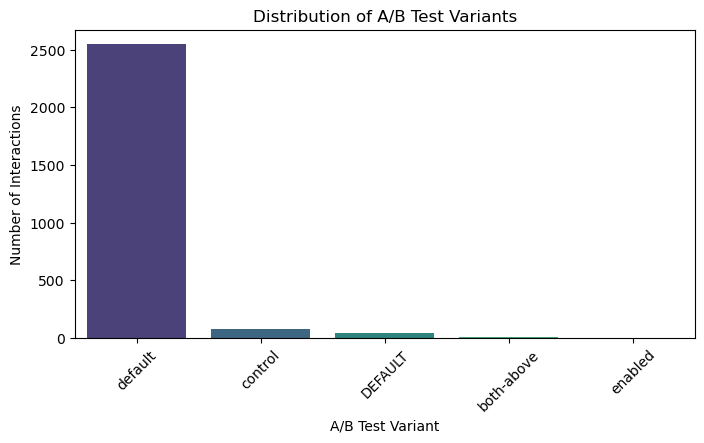

In [30]:
# Plot A/B test variant distribution
plt.figure(figsize=(8,4))
sns.barplot(x=variant_counts.index, y=variant_counts.values, palette="viridis")

# Labels and title
plt.xlabel("A/B Test Variant")
plt.ylabel("Number of Interactions")
plt.title("Distribution of A/B Test Variants")
plt.xticks(rotation=45)
plt.show()

<Figure size 1200x500 with 0 Axes>

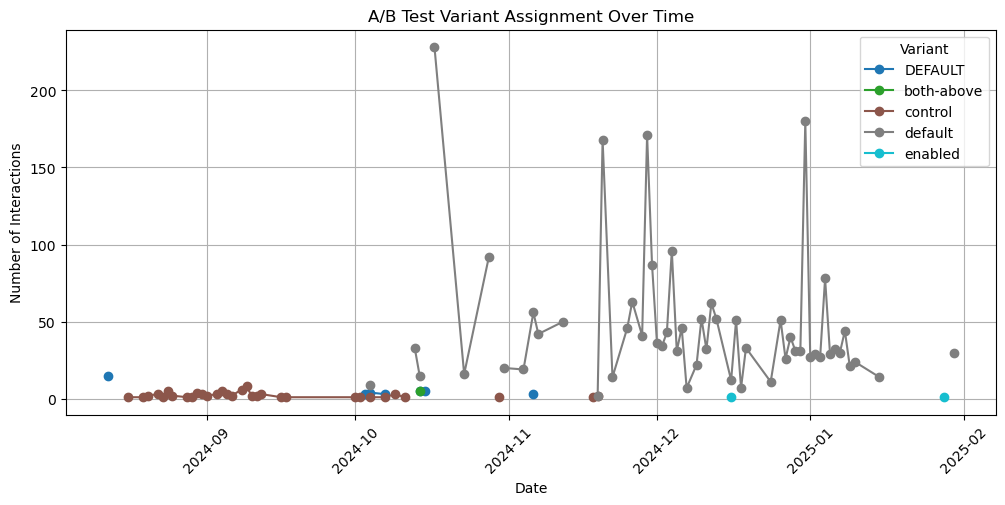

In [31]:
# Group by timestamp and count occurrences of each variant over time
df_time_series = df_cleaned.groupby([df_cleaned["timestamp_utc"].dt.date, "message_variant"]).size().unstack()

# Plot time trends
plt.figure(figsize=(12,5))
df_time_series.plot(kind="line", marker="o", figsize=(12,5), colormap="tab10")
plt.xlabel("Date")
plt.ylabel("Number of Interactions")
plt.title("A/B Test Variant Assignment Over Time")
plt.legend(title="Variant")
plt.xticks(rotation=45)
plt.grid()
plt.show()

<Figure size 1200x500 with 0 Axes>

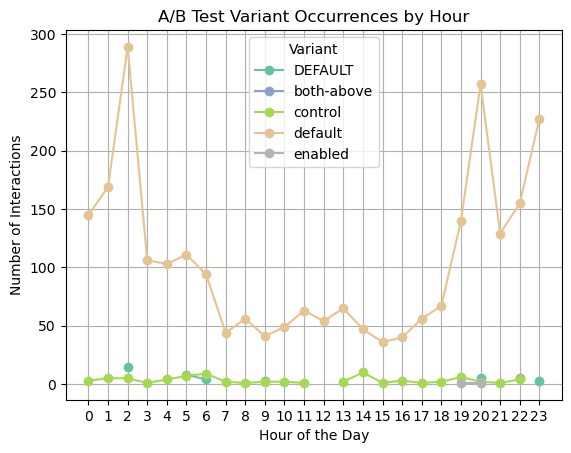

In [32]:
# Extract hour of day
df_cleaned["hour"] = df_cleaned["timestamp_utc"].dt.hour

# Count occurrences by hour
hourly_counts = df_cleaned.groupby(["hour", "message_variant"]).size().unstack()

# Plot hourly trends
plt.figure(figsize=(12,5))
hourly_counts.plot(kind="line", marker="o", colormap="Set2")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Interactions")
plt.title("A/B Test Variant Occurrences by Hour")
plt.xticks(range(0,24))
plt.legend(title="Variant")
plt.grid()
plt.show()

**Analyzing My Playlist Interaction Trends Over Time**

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

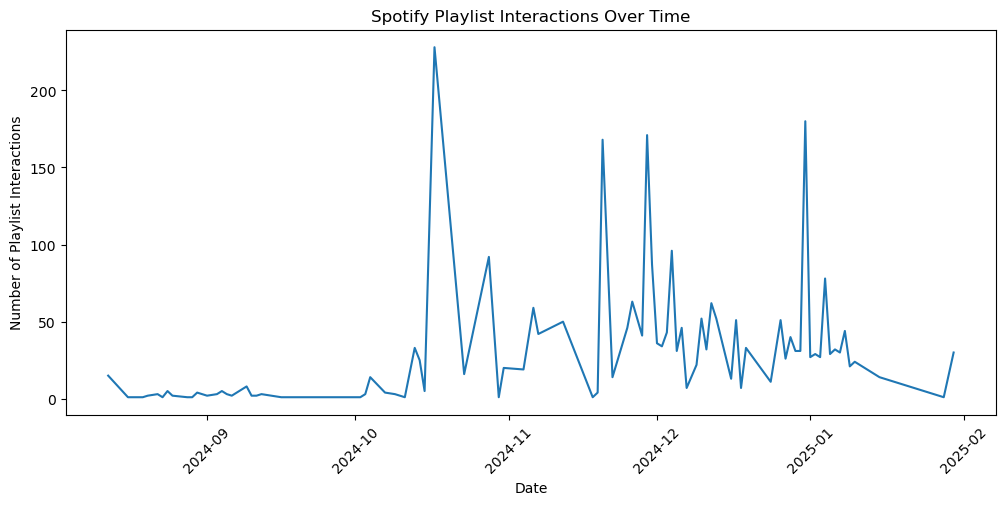

In [34]:
# Group by date
df_cleaned["date"] = df_cleaned["timestamp_utc"].dt.date
daily_interactions = df_cleaned.groupby("date").size()

# Plot interaction trends
plt.figure(figsize=(12,5))
sns.lineplot(x=daily_interactions.index, y=daily_interactions.values)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Number of Playlist Interactions")
plt.title("Spotify Playlist Interactions Over Time")
plt.show()

# **Analyzing Device Usage**

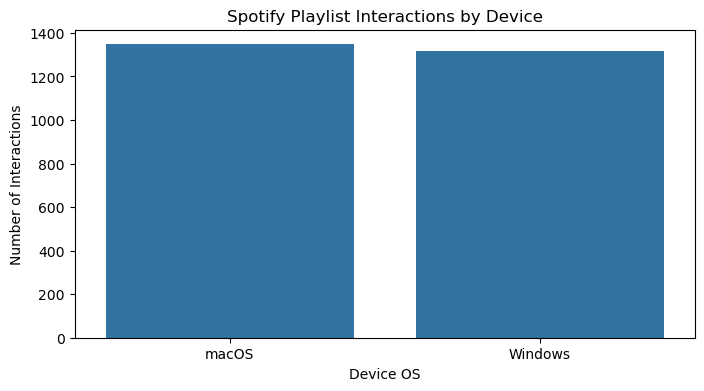

In [35]:
# Count occurrences of each OS
os_counts = df_cleaned["message_os"].value_counts()

# Plot device usage
plt.figure(figsize=(8,4))
sns.barplot(x=os_counts.index, y=os_counts.values)
plt.xlabel("Device OS")
plt.ylabel("Number of Interactions")
plt.title("Spotify Playlist Interactions by Device")
plt.show()

- It looks like I interact with Spotify almost equally on both Windows and macOS. The number of interactions on each system is nearly the same, which suggests that I switch between both devices pretty often.

- This could mean I use Windows for work or certain tasks and macOS for leisure, or I just alternate between them depending on convenience. Interestingly, there’s no data for mobile or tablet usage, which makes me wonder if those interactions weren’t recorded in this dataset.

- If I wanted to dig deeper, I could check whether I tend to use one OS more at certain times of the day—maybe I listen more on Windows during work hours and macOS in the evenings. It would also be interesting to see if I engage differently on each OS, like skipping songs more on one device or spending more time exploring playlists on another.

- Overall, this tells me that my Spotify usage is pretty balanced across my desktop devices, but it leaves the question open about how much I use Spotify on mobile.

---

<Figure size 1200x600 with 0 Axes>

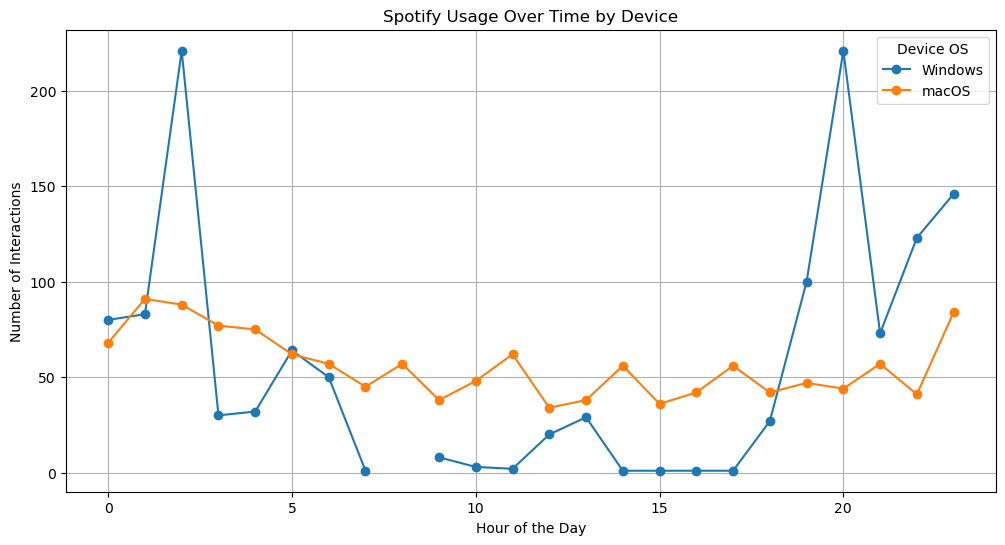

In [41]:
# Extract hour from timestamp
df_cleaned["hour"] = df_cleaned["timestamp_utc"].dt.hour

# Group by hour and OS to count interactions
hourly_os_usage = df_cleaned.groupby(["hour", "message_os"]).size().unstack()

# Plot
plt.figure(figsize=(12,6))
hourly_os_usage.plot(kind="line", marker="o", figsize=(12,6))
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Interactions")
plt.title("Spotify Usage Over Time by Device")
plt.legend(title="Device OS")
plt.grid()
plt.show()

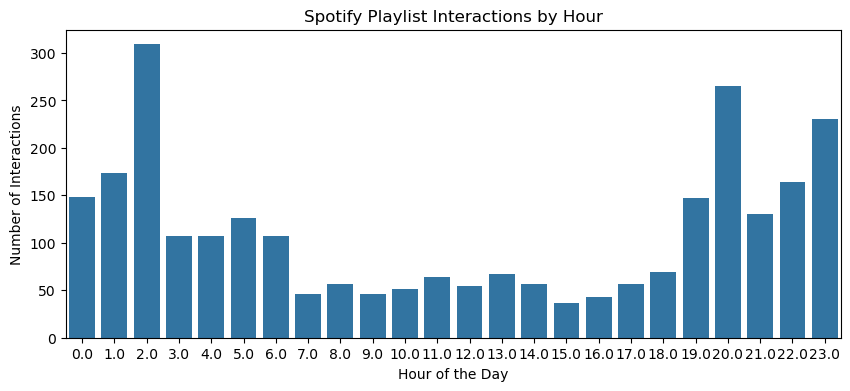

In [36]:
# Extract hour of the day
df_cleaned["hour"] = df_cleaned["timestamp_utc"].dt.hour

# Count interactions per hour
hourly_counts = df_cleaned.groupby("hour").size()

# Plot
plt.figure(figsize=(10,4))
sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Interactions")
plt.title("Spotify Playlist Interactions by Hour")
plt.show()

C:\Users\kcalo\AppData\Local\Temp\ipykernel_1776\2636981568.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_category_counts.index, y=hourly_category_counts.values, palette="magma")


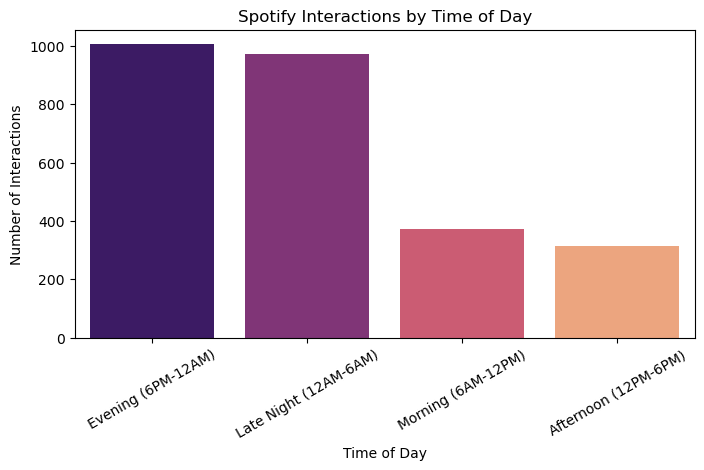

In [37]:
# Create a new column for AM/PM grouping
df_cleaned["hour_category"] = df_cleaned["hour"].apply(lambda x: "Morning (6AM-12PM)" if 6 <= x < 12 else
                                                         "Afternoon (12PM-6PM)" if 12 <= x < 18 else
                                                         "Evening (6PM-12AM)" if 18 <= x < 24 else
                                                         "Late Night (12AM-6AM)")

# Count interactions per category
hourly_category_counts = df_cleaned["hour_category"].value_counts()

# Plot the categorized interactions
plt.figure(figsize=(8,4))
sns.barplot(x=hourly_category_counts.index, y=hourly_category_counts.values, palette="magma")
plt.xlabel("Time of Day")
plt.ylabel("Number of Interactions")
plt.title("Spotify Interactions by Time of Day")
plt.xticks(rotation=30)
plt.show()

**Spotify Usage Over Time by Device**

This analysis examines my **Spotify interactions throughout the day**, separated by **Windows and macOS usage**. The data highlights how my listening habits align with my daily activities.

**1. Early Morning Peak (12 AM - 3 AM) 📈**
- **Windows usage spikes dramatically right after midnight**, reaching its highest point around 1 AM.
- After this peak, **Windows activity drops sharply**, almost hitting zero before 4 AM.
- **macOS usage remains more consistent** during this period, though never as high as Windows.

**2. Morning to Afternoon (4 AM - 4 PM) ☀️**
- **Windows activity is minimal**, indicating that I don’t use this device for Spotify much during work hours.
- **macOS usage remains steady**, suggesting I listen to music passively while working, browsing, or studying.
- This aligns with my routine—**I use macOS for general tasks, while Windows is strictly for coding and data analysis projects.**

**3. Evening & Late Night (6 PM - 11 PM) 🌙**
- **A second major Windows spike occurs between 8-10 PM**, suggesting focused listening sessions, likely while working on projects.
- **macOS activity is evenly spread throughout the day**, implying background listening rather than active interaction.

✔ **Windows is used for bursts of high activity**, aligning with focused work sessions for **data analysis and coding projects**.  
✔ **macOS is used consistently for passive listening**, reflecting a more relaxed or multitasking environment.  
✔ **My Spotify listening habits change based on device usage**, reinforcing the connection between my work patterns and how I engage with music.

---

C:\Users\kcalo\AppData\Local\Temp\ipykernel_1776\629773806.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="coolwarm")


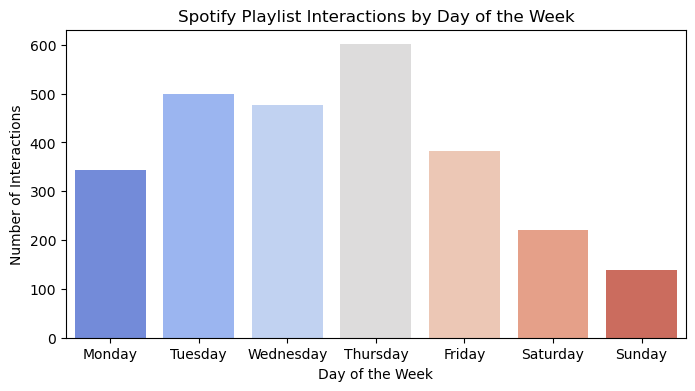

In [38]:
# Extract weekday name
df_cleaned["weekday"] = df_cleaned["timestamp_utc"].dt.day_name()

# Count interactions per day
weekday_counts = df_cleaned["weekday"].value_counts()

# Reorder to Monday-Sunday
weekday_counts = weekday_counts.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="coolwarm")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Interactions")
plt.title("Spotify Playlist Interactions by Day of the Week")
plt.show()

**Spotify Usage by Day of the Week**

The bar chart above illustrates how frequently I interact with Spotify on different days of the week. A few clear trends emerge:

- Thursday stands out as the most active day, with significantly higher Spotify interactions than any other day.
- Monday to Wednesday show relatively steady engagement, indicating that I consistently listen to music at the start of the workweek.
- Friday shows a noticeable decline, suggesting that I may be transitioning away from work-related listening habits.
- Saturday and Sunday have the lowest activity, implying that I spend less time engaging with Spotify during weekends.

My Spotify engagement aligns with a weekday-heavy listening pattern, where I am most active from Monday through Thursday. This suggests that I use music as a way to stay focused while working on projects and tasks during the week. The sharp drop on weekends indicates that I likely spend more time relaxing and unwinding, using music in a more casual or background setting rather than as a productivity tool.

---

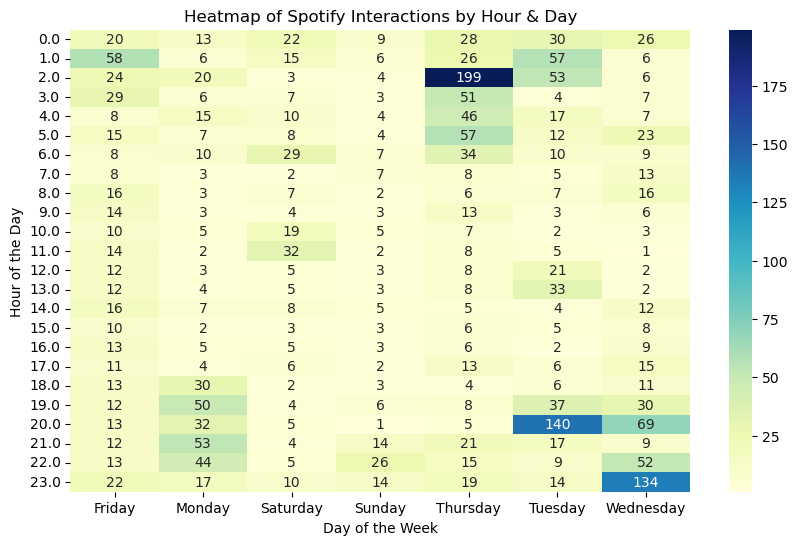

In [39]:
# Create a pivot table for heatmap
heatmap_data = df_cleaned.pivot_table(index=df_cleaned["hour"], columns=df_cleaned["weekday"], aggfunc="size", fill_value=0)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel("Day of the Week")
plt.ylabel("Hour of the Day")
plt.title("Heatmap of Spotify Interactions by Hour & Day")
plt.show()

**Hourly Heatmap: When Do I Listen to Spotify the Most?**

The heatmap provides deeper insights into the specific hours of each day when I interact with Spotify the most.

- Late Night & Early Morning Spikes (Midnight - 3 AM) 
    - Tuesday and Thursday show strong engagement at 2-3 AM, with peak interactions reaching 199 plays on Thursday at 2 AM.
    - A possible reason could be that I stay up late working on projects or unwinding before bed.
        - The majority of my workweek is done by the end of Thursday.

- Workday Peaks (10 AM - 5 PM) 
    - Spotify activity remains moderate across most weekdays, suggesting background music usage during work.
    - Wednesday shows a small midday boost (12 PM - 3 PM), possibly indicating a midweek productivity push.

- Evening Resurgence (8 PM - 11 PM) 
    - A major peak occurs on Tuesday at 10 PM (140 interactions) and again on Wednesday at 11 PM (134 interactions).
    - This suggests a pattern of engaging with Spotify in the late evening, potentially for relaxation or focused work.

✔ Thursday is the dominant listening day, with a massive late-night peak at 2 AM.

✔ Tuesday and Wednesday show late-night surges, aligning with my work or focus sessions.

✔ Spotify use decreases significantly on weekends, suggesting other activities take priority.

---

# **Interaction By Hour**

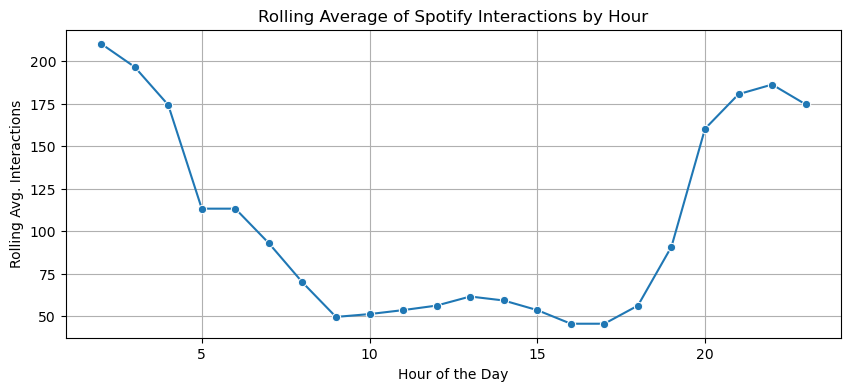

In [40]:
# Create a rolling average of interactions per hour
df_hourly_trends = df_cleaned.groupby("hour").size().rolling(window=3).mean()

# Plot rolling trend
plt.figure(figsize=(10,4))
sns.lineplot(x=df_hourly_trends.index, y=df_hourly_trends.values, marker="o")
plt.xlabel("Hour of the Day")
plt.ylabel("Rolling Avg. Interactions")
plt.title("Rolling Average of Spotify Interactions by Hour")
plt.grid()
plt.show()